<a href="https://colab.research.google.com/github/UoA-eResearch/deep-learning-tutorial-2019/blob/master/Exercise%203%20-%20conv%20nets%20mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 3: MNIST
Lets first look at [this fun video](https://www.youtube.com/watch?v=p_7GWRup-nQ) or [this technical video](https://www.youtube.com/watch?v=FmpDIaiMIeA) to get an understanding of what a convolutional neural network is.

### Goal in this exercise
We will create a convolutional neural network that classifies handwritten digits (0-9) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The MNIST dataset has 60,000 training examples and 10,000 test samples. The digits are normalised for size and centred.

![MNIST Digits](https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

### Q: How many output classes do we have in this problem? Please name the type of problem we are trying to solve.

*Answer...*

*This is a multi-class classification problem. The main difference between the previous exercises is that we are now processing images rather than a vector of numbers. Also, we are going to use the GPU to speed up computation.*

#### To use GPU on the Google Colab notebook,

Navigate to the "Runtime" tab --> "Change runtime type". In the pop-up window, under "Hardware accelerator" select "GPU".

#### The last step of this exercise contains a task.

### Import dependencies
Start by importing the dependencies we will need for the project

In [1]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

if K.image_dim_ordering() != "tf":
  print("Backend image dimension ordering is inappropriate. Change it by typing K.image_dim_ordering('tf')")

Using TensorFlow backend.


In [0]:
def plot_acc_loss(history):
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
    
    # Summarize history of accuracy
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # Summarize history of accuracy
    ax2.plot(history.history['acc'])
    ax2.plot(history.history['val_acc'])
    ax2.set_title('model accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

### Set seed
Set a seed value so that when we repeatedly run our code we will get the same result. Using the same seed is important when you want to compare algorithms.

In [0]:
seed = 7
numpy.random.seed(seed)

### Import data
The MNIST dataset has  60,000 training samples and 10,000 test samples.

Keras includes a number of datasets, including MNIST in the `keras.datasets` module. To download the MNIST dataset call `mnist.load_data()`.

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


A two dimensional convolutional neural network expects data to be arranged in a four dimensional shape: *number of samples*  x  *width*  x *height*  x *channels*.

For example, assume we have 10 RGB images, with widths and heights of 20 pixels. This would need to be shaped into 10 samples, each RGB channel would be split into three separate images (1 for red, 1 for green and 1 for blue). Each image would then be a 2D array with 20 rows and columns.

The MNIST data has the wrong shape for a 2D convolutional neural network (3 dimensions rather than four):

In [5]:
print(X_train.shape)

(60000, 28, 28)


The data is missing the dimension for channels, so we need to reshape the data to add it in. The images in the MNIST example are gray scale, so they only have 1 channel.

This is done using the numpy `reshape` method.

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [7]:
X_train.shape

(60000, 28, 28, 1)

Normalize the pixels to the range 0 - 1

#### Understanding image data

In [0]:
X_train = X_train / 255
X_test = X_test / 255

0


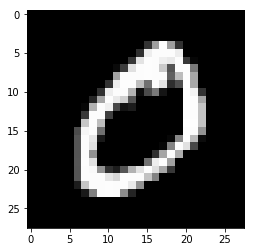

In [9]:
# Show the first image in the train dataset and the corresponding output variable
plt.imshow(np.array(X_train[1,:,:,0]), cmap='gray')
print(y_train[1])

In [10]:
# Showing the pixel values
five = X_train[1].reshape(28,28)
for row in range(28):
  for col in range(28):
    print("%.F " % five[row][col], end="")
  print("")

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0

In [11]:
y_train[1:10]

array([0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

One hot encode the target variables as you did in the Iris classification exercise. The data is already numeric so you do not need to use the LabelEncoder.

In [12]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print("Number of classes: {0}".format(num_classes))

Number of classes: 10


### Create the model

1. The input layer takes inputs with a dimension 28x28x1
2. The first hidden layer is a `Conv2D` layer. We have set it to have 30 filters (the number of output filters) and the size of the kernel to 5x5.
3. The `MaxPooling2D` has a kernel size of 2x2. This downsamples the output of the previous layer by selecting the maxiumum value in each kernel. An example is illustrated below: 

![Max pooling](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)
4. The `Dropout` layer is used to prevent overfitting. It does this by randomly turning off neurons (50% in this example). 
![Dropout layer](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)
5. The `Flatten` layer flattens the Conv2D layers into a normal fully connected layer that can be connected to a Dense layer. 
![Flatten layer](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png)
6. A `Dense` fully connected layer is added with 50 neurons.
7. The last layer is the output layer, which has 10 neurons (one for each class/digit).

In [13]:
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu', kernel_initializer='normal'))
model.add(Dense(num_classes, activation='softmax', kernel_initializer='normal'))

W0701 04:51:14.285164 139733662820224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 04:51:14.319924 139733662820224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 04:51:14.326993 139733662820224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 04:51:14.364472 139733662820224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0701 04:51:14.367571 139733662820224 deprecation_wrapp

### Compile the model
The next step is to compile the model. The loss function (`categorical_crossentropy`) is the same as the Iris multi-class classification exercise.

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0701 04:51:14.449603 139733662820224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Fit the model
The next step is to train the model. It takes a lot more computing resources to train convultional neural networks, so note that far less `epochs` are used, but a much larger `batch_size` is used due to a much larger data set.

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

W0701 04:51:17.708031 139733662820224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 493us/step - loss: 0.4058 - acc: 0.8842 - val_loss: 0.1336 - val_acc: 0.9620
Epoch 2/10
60000/60000 [==============================] - 29s 478us/step - loss: 0.1204 - acc: 0.9650 - val_loss: 0.0701 - val_acc: 0.9787
Epoch 3/10
60000/60000 [==============================] - 29s 482us/step - loss: 0.0814 - acc: 0.9761 - val_loss: 0.0535 - val_acc: 0.9820
Epoch 4/10
60000/60000 [==============================] - 29s 482us/step - loss: 0.0646 - acc: 0.9802 - val_loss: 0.0532 - val_acc: 0.9835
Epoch 5/10
60000/60000 [==============================] - 29s 480us/step - loss: 0.0544 - acc: 0.9835 - val_loss: 0.0427 - val_acc: 0.9863
Epoch 6/10
60000/60000 [==============================] - 29s 482us/step - loss: 0.0460 - acc: 0.9860 - val_loss: 0.0382 - val_acc: 0.9867
Epoch 7/10
60000/60000 [==============================] - 29s 481us/step - loss: 0.0408 - acc: 0.9874 - val_loss: 0.

In [0]:
plot_acc_loss(history)

### Evaluate the model
Now that we have trained our model, we can evaluate the performance on the test data.

In [0]:
scores = model.evaluate(numpy.concatenate((X_train, X_test), axis=0), numpy.concatenate((y_train, y_test), axis=0), verbose=0)
print("Accuracy: {0:.2f}%, Error: {1:.2f}%. ".format(scores[1]*100, 100-scores[1]*100))

In [0]:
# Combing train and test datasets
X = numpy.concatenate((X_train, X_test), axis=0)
y=np.concatenate((y_train,y_test),axis=0)
                     

In [0]:
y_pred = model.predict_classes(X)

In [0]:
y

In [0]:

y=np.asarray([np.where(r==1)[0][0] for r in y])

In [0]:
matrix = metrics.confusion_matrix(y, y_pred) # (y_true,y_pred)
print(matrix)

### Visualising errors


In [0]:
pred_right = y == y_pred

wrong = [i for i, pred in enumerate(pred_right) if pred==False]

error_example = wrong[0]

plt.imshow(X[error_example,:,:,0])
print("{0}>{1}".format(y[error_example], y_pred[error_example]))

# Key Points


*  Convolutional neural network
*   Image data structure for a 2D convolutional neural network
*  Some of the layers we can use in our model (e.g., max pooling, dropout)



### Network topologies
Changing the structure of a neural network is one of the best methods for improving the accuracy of a neural network. There are two key ways to change your network topology:

* Create a deeper network topology
* Create a wider network topology

Here are some examples of what this means in the context of the network used in the Iris neural network - exercise 2.

#### Baseline
This was our baseline model for the iris dataset:
```python
model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu', kernel_initializer='normal'))
model.add(Dense(3, activation='sigmoid', kernel_initializer='normal'))
```

#### Deeper
In a deeper network topology you simply increase the number of layers:
```python
model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu', kernel_initializer='normal'))
model.add(Dense(4, activation='relu', kernel_initializer='normal'))
model.add(Dense(3, activation='sigmoid', kernel_initializer='normal'))
```

#### Wider
In a wider network topology you increase the number of neurons in the hidden layers:
```python
model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu', kernel_initializer='normal'))
model.add(Dense(3, activation='sigmoid', kernel_initializer='normal'))
```

## Task 2: create different network topologies
Create a model with a wider and deeper network topology and see how it performs with regards to the simpler model.

Hints:
* Think about adding more Conv2D and MaxPooling2D layers, followed by the Flatten layer and Dense layers that decrease in the number of neurons (hundreds -> num_classes)